<Figure size 1200x800 with 0 Axes>

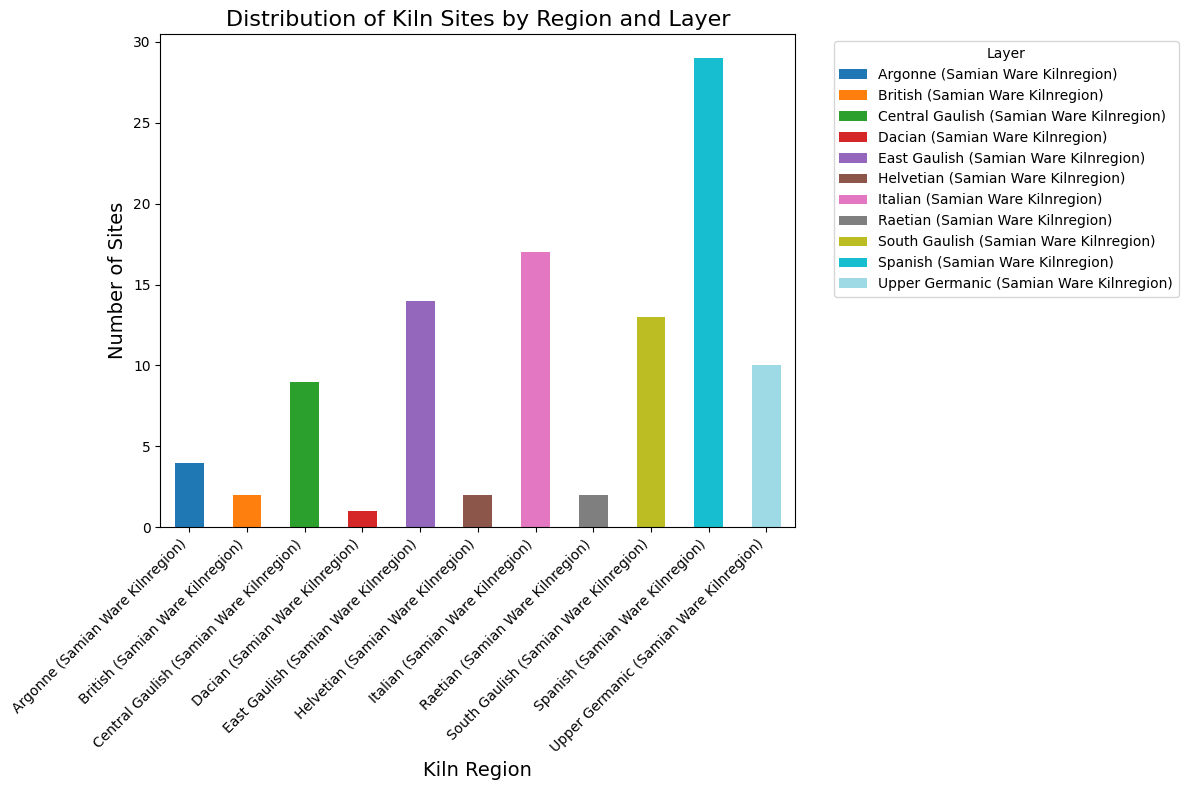

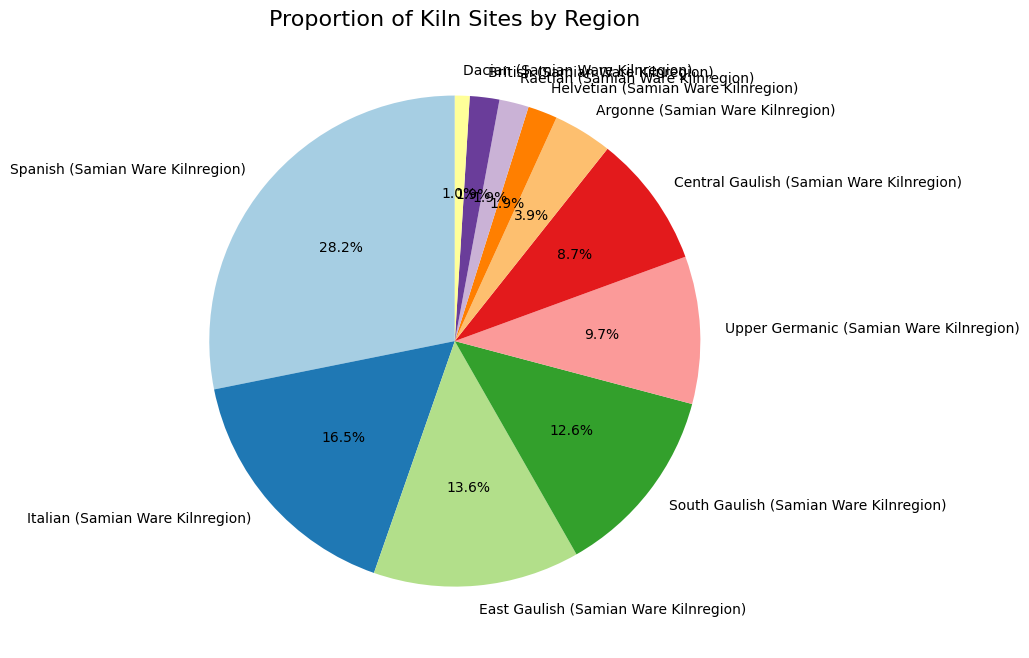

In [1]:

from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import matplotlib.pyplot as plt

def querySparql(query):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    return results['results']['bindings']

# SPARQL Query for Samian Ware Kiln Sites
samianQuery = """
SELECT ?item ?samian ?itemLabel ?geo ?layerLabel ?layer ?kilnregion ?kilnregionLabel WHERE {
  ?item wdt:P31 wd:Q102202026;
    wdt:P361 wd:Q90412636;
    wdt:P706 ?kilnregion;
    wdt:P2888 ?samian;
    wdt:P625 ?geo;
    wdt:P706 ?layer.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""

# Fetch data using the SPARQL query
sparql_results = querySparql(samianQuery)

# Convert SPARQL JSON results into a DataFrame
data = []
for result in sparql_results:
    geo = result.get('geo', {}).get('value', None)
    lat, lon = None, None
    if geo:
        coords = geo.replace("Point(", "").replace(")", "").split()
        if len(coords) == 2:
            lon, lat = map(float, coords)
    data.append({
        "item": result.get("item", {}).get("value", None),
        "itemLabel": result.get("itemLabel", {}).get("value", None),
        "layerLabel": result.get("layerLabel", {}).get("value", None),
        "kilnregionLabel": result.get("kilnregionLabel", {}).get("value", None),
        "latitude": lat,
        "longitude": lon,
    })

df = pd.DataFrame(data)

# Check if DataFrame is populated
if df.empty:
    print("No data retrieved from the query.")
else:
    # Count sites by region and layer for stacked bar chart
    region_layer_counts = df.groupby(["kilnregionLabel", "layerLabel"]).size().unstack(fill_value=0)
    
    # Create pie chart data
    region_counts = df["kilnregionLabel"].value_counts()
    
    # Stacked Bar Chart
    plt.figure(figsize=(12, 8))
    region_layer_counts.plot(kind="bar", stacked=True, figsize=(12, 8), colormap="tab20")
    plt.title("Distribution of Kiln Sites by Region and Layer", fontsize=16)
    plt.xlabel("Kiln Region", fontsize=14)
    plt.ylabel("Number of Sites", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Layer", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # Pie Chart
    plt.figure(figsize=(10, 10))
    region_counts.plot(kind="pie", autopct="%1.1f%%", startangle=90, colors=plt.cm.Paired.colors)
    plt.title("Proportion of Kiln Sites by Region", fontsize=16)
    plt.ylabel("")  # Remove default ylabel
    plt.tight_layout()
    plt.show()
